In [1]:
%run ./Definitions.ipynb

2019-12-25 02:23:15.504539
thunder  Wed Dec 25 02:23:15 2019
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |  8605 / 11178 MB | patra(8595M)
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % |   699 / 11178 MB | srikanth(689M)
[7] GeForce GTX 1080 Ti | 28'C,   0 % | 10936 / 11178 MB | hemelinr(10926M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Wed Dec 25 02:23:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

In [9]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

## Define Model and Metrics

In [10]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
    
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [12]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [13]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True, featurewise_center=True, 
                                 featurewise_std_normalization=True, rescale= 1./127.5-1)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 198910 validated image filenames.
Found 33943 validated image filenames.


In [14]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.0001 
decay = 1e-5
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [15]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
keras_model_path = funduspath_CR + 'Models/'
n_epochs=299
n_steps_per_epoch = 50
n_validation_steps = 10

In [16]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/299


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 43s 860ms/step - loss: 0.7366 - Accuracy: 0.5756 - Precision: 0.5641 - Recall: 0.4498 - F1: 0.4666 - AUC: 0.5972 - val_loss: 1.8645 - val_Accuracy: 0.0250 - val_Precision: 0.0219 - val_Recall: 0.6000 - val_F1: 0.0421 - val_AUC: 0.6926
Epoch 2/299
50/50 [==============================] - 45s 901ms/step - loss: 0.6427 - Accuracy: 0.6344 - Precision: 0.6454 - Recall: 0.6574 - F1: 0.6401 - AUC: 0.6954 - val_loss: 0.0875 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6518
Epoch 3/299
50/50 [==============================] - 48s 963ms/step - loss: 0.6549 - Accuracy: 0.6244 - Precision: 0.6268 - Recall: 0.6147 - F1: 0.6090 - AUC: 0.6820 - val_loss: 1.3065 - val_Accuracy: 0.0656 - val_Precision: 0.0031 - val_Recall: 0.1000 - val_F1: 0.0061 - val_AUC: 0.2594
Epoch 4/299
50/50 [==============================] - 45s 904ms/step - loss: 0.6352 - Accuracy: 0.6344 - Precision: 0.6179 - Recall: 0.63

Epoch 29/299
50/50 [==============================] - 51s 1s/step - loss: 0.5330 - Accuracy: 0.7300 - Precision: 0.7271 - Recall: 0.7596 - F1: 0.7353 - AUC: 0.8101 - val_loss: 1.4806 - val_Accuracy: 0.0656 - val_Precision: 0.0412 - val_Recall: 0.7000 - val_F1: 0.0771 - val_AUC: 0.7578
Epoch 30/299
50/50 [==============================] - 52s 1s/step - loss: 0.5431 - Accuracy: 0.7387 - Precision: 0.7206 - Recall: 0.7811 - F1: 0.7427 - AUC: 0.8030 - val_loss: 1.4375 - val_Accuracy: 0.0250 - val_Precision: 0.0097 - val_Recall: 0.3000 - val_F1: 0.0187 - val_AUC: 0.5247
Epoch 31/299
50/50 [==============================] - 51s 1s/step - loss: 0.5827 - Accuracy: 0.6844 - Precision: 0.6920 - Recall: 0.7111 - F1: 0.6952 - AUC: 0.7570 - val_loss: 1.6296 - val_Accuracy: 0.0437 - val_Precision: 0.0226 - val_Recall: 0.5000 - val_F1: 0.0427 - val_AUC: 0.6127
Epoch 32/299
50/50 [==============================] - 52s 1s/step - loss: 0.5603 - Accuracy: 0.7069 - Precision: 0.7139 - Recall: 0.7317 - F1:

Epoch 86/299
50/50 [==============================] - 53s 1s/step - loss: 0.5515 - Accuracy: 0.7169 - Precision: 0.7123 - Recall: 0.7325 - F1: 0.7156 - AUC: 0.7911 - val_loss: 1.5038 - val_Accuracy: 0.0312 - val_Precision: 0.0126 - val_Recall: 0.4000 - val_F1: 0.0244 - val_AUC: 0.6171
Epoch 87/299
50/50 [==============================] - 53s 1s/step - loss: 0.5634 - Accuracy: 0.7063 - Precision: 0.6989 - Recall: 0.7372 - F1: 0.7092 - AUC: 0.7798 - val_loss: 1.4932 - val_Accuracy: 0.0437 - val_Precision: 0.0130 - val_Recall: 0.3000 - val_F1: 0.0248 - val_AUC: 0.5396
Epoch 88/299
50/50 [==============================] - 53s 1s/step - loss: 0.5648 - Accuracy: 0.6975 - Precision: 0.6954 - Recall: 0.7140 - F1: 0.6976 - AUC: 0.7740 - val_loss: 1.3862 - val_Accuracy: 0.0500 - val_Precision: 0.0223 - val_Recall: 0.4000 - val_F1: 0.0421 - val_AUC: 0.3576
Epoch 89/299
50/50 [==============================] - 53s 1s/step - loss: 0.5316 - Accuracy: 0.7487 - Precision: 0.7634 - Recall: 0.7637 - F1:

Epoch 115/299
50/50 [==============================] - 51s 1s/step - loss: 0.5398 - Accuracy: 0.7275 - Precision: 0.7208 - Recall: 0.7468 - F1: 0.7268 - AUC: 0.8063 - val_loss: 1.5828 - val_Accuracy: 0.0688 - val_Precision: 0.0422 - val_Recall: 0.8000 - val_F1: 0.0794 - val_AUC: 0.5879
Epoch 116/299
50/50 [==============================] - 50s 999ms/step - loss: 0.5531 - Accuracy: 0.7125 - Precision: 0.7113 - Recall: 0.7341 - F1: 0.7170 - AUC: 0.7891 - val_loss: 1.4630 - val_Accuracy: 0.0375 - val_Precision: 0.0282 - val_Recall: 0.6000 - val_F1: 0.0537 - val_AUC: 0.5098
Epoch 117/299
50/50 [==============================] - 51s 1s/step - loss: 0.5520 - Accuracy: 0.7081 - Precision: 0.6984 - Recall: 0.7341 - F1: 0.7101 - AUC: 0.7872 - val_loss: 1.5257 - val_Accuracy: 0.0750 - val_Precision: 0.0256 - val_Recall: 0.4000 - val_F1: 0.0478 - val_AUC: 0.4032
Epoch 118/299
50/50 [==============================] - 51s 1s/step - loss: 0.5539 - Accuracy: 0.7163 - Precision: 0.7174 - Recall: 0.734

50/50 [==============================] - 49s 986ms/step - loss: 0.5389 - Accuracy: 0.7244 - Precision: 0.7139 - Recall: 0.7466 - F1: 0.7230 - AUC: 0.8051 - val_loss: 1.5516 - val_Accuracy: 0.0406 - val_Precision: 0.0225 - val_Recall: 0.5500 - val_F1: 0.0430 - val_AUC: 0.2909
Epoch 172/299
50/50 [==============================] - 50s 1s/step - loss: 0.5341 - Accuracy: 0.7294 - Precision: 0.7044 - Recall: 0.7699 - F1: 0.7293 - AUC: 0.8096 - val_loss: 1.4136 - val_Accuracy: 0.0312 - val_Precision: 0.0252 - val_Recall: 0.6000 - val_F1: 0.0482 - val_AUC: 0.2905
Epoch 173/299
50/50 [==============================] - 50s 1s/step - loss: 0.5403 - Accuracy: 0.7319 - Precision: 0.7182 - Recall: 0.7690 - F1: 0.7338 - AUC: 0.8068 - val_loss: 1.2378 - val_Accuracy: 0.0437 - val_Precision: 0.0161 - val_Recall: 0.3000 - val_F1: 0.0301 - val_AUC: 0.7035
Epoch 174/299
50/50 [==============================] - 50s 1s/step - loss: 0.5450 - Accuracy: 0.7356 - Precision: 0.7438 - Recall: 0.7540 - F1: 0.7416

50/50 [==============================] - 50s 994ms/step - loss: 0.5653 - Accuracy: 0.7050 - Precision: 0.7046 - Recall: 0.7388 - F1: 0.7108 - AUC: 0.7782 - val_loss: 1.3984 - val_Accuracy: 0.0656 - val_Precision: 0.0354 - val_Recall: 0.8000 - val_F1: 0.0675 - val_AUC: 0.6224
Epoch 228/299
50/50 [==============================] - 51s 1s/step - loss: 0.5330 - Accuracy: 0.7269 - Precision: 0.7501 - Recall: 0.7224 - F1: 0.7290 - AUC: 0.8131 - val_loss: 1.5543 - val_Accuracy: 0.0406 - val_Precision: 0.0221 - val_Recall: 0.6000 - val_F1: 0.0424 - val_AUC: 0.7054
Epoch 229/299
50/50 [==============================] - 50s 996ms/step - loss: 0.5353 - Accuracy: 0.7419 - Precision: 0.7303 - Recall: 0.7723 - F1: 0.7442 - AUC: 0.8121 - val_loss: 1.3499 - val_Accuracy: 0.0750 - val_Precision: 0.0415 - val_Recall: 0.8000 - val_F1: 0.0780 - val_AUC: 0.4915
Epoch 230/299
50/50 [==============================] - 51s 1s/step - loss: 0.5243 - Accuracy: 0.7519 - Precision: 0.7292 - Recall: 0.7892 - F1: 0.7

50/50 [==============================] - 50s 1s/step - loss: 0.5459 - Accuracy: 0.7300 - Precision: 0.7188 - Recall: 0.7622 - F1: 0.7295 - AUC: 0.8010 - val_loss: 1.5300 - val_Accuracy: 0.0469 - val_Precision: 0.0191 - val_Recall: 0.5000 - val_F1: 0.0366 - val_AUC: 0.5194
Epoch 284/299
50/50 [==============================] - 50s 1s/step - loss: 0.5321 - Accuracy: 0.7406 - Precision: 0.7350 - Recall: 0.7743 - F1: 0.7458 - AUC: 0.8155 - val_loss: 1.4201 - val_Accuracy: 0.0875 - val_Precision: 0.0337 - val_Recall: 0.4500 - val_F1: 0.0613 - val_AUC: 0.7292
Epoch 285/299
50/50 [==============================] - 50s 1s/step - loss: 0.5280 - Accuracy: 0.7350 - Precision: 0.7264 - Recall: 0.7511 - F1: 0.7323 - AUC: 0.8185 - val_loss: 1.4141 - val_Accuracy: 0.0594 - val_Precision: 0.0230 - val_Recall: 0.4667 - val_F1: 0.0434 - val_AUC: 0.4794
Epoch 286/299
50/50 [==============================] - 51s 1s/step - loss: 0.5468 - Accuracy: 0.7344 - Precision: 0.7142 - Recall: 0.7541 - F1: 0.7241 - 

In [17]:
print("Time taken:",end-start)

Time taken: 15176.214772701263


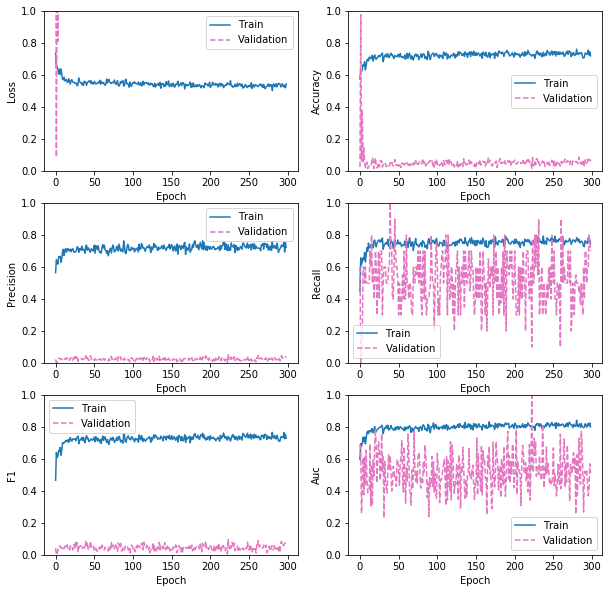

In [18]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [19]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 16s 162ms/step


In [20]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 0.867 :   1.496
Accuracy : 0.536 :   0.061
Precision : 0.522 :   0.022
Recall : 0.939 :   0.510
F1 : 0.667 :   0.041
AUC : 0.573 :   0.488


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [21]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(6162.142127275467, 156.34237432479858)

In [22]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [23]:
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_tr_78_featurewise.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_vl_78_featurewise.npy', pred_vl)

### ROC Curve

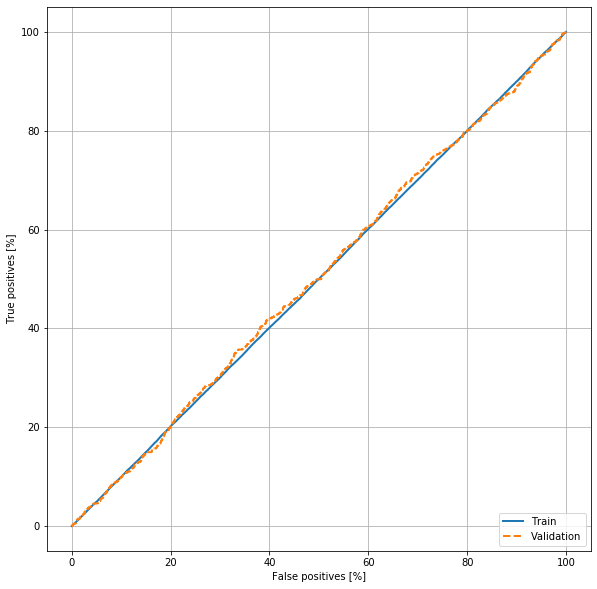

In [24]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 8849 
FP: 90606 
FN: 8902 
TP: 90553
Healthy Patients - correctly identified (True Negatives):  8849 0.08897491327736162
Healthy Patients - predicted to have glaucoma (False Positives):  90606 0.9110250867226384
Glaucoma Patients - predicted healthy (False Negatives):  8902 0.08950781760595244
Glaucoma Patients - correctly identified (True Positives):  90553 0.9104921823940476

Total Glaucoma patients:  99455 1.0
Total Healthy patients:  99455 1.0


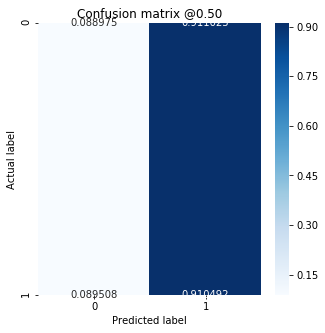

In [25]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 1397 
FP: 31737 
FN: 37 
TP: 772
Healthy Patients - correctly identified (True Negatives):  1397 0.04216212953461701
Healthy Patients - predicted to have glaucoma (False Positives):  31737 0.957837870465383
Glaucoma Patients - predicted healthy (False Negatives):  37 0.04573547589616811
Glaucoma Patients - correctly identified (True Positives):  772 0.9542645241038319

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


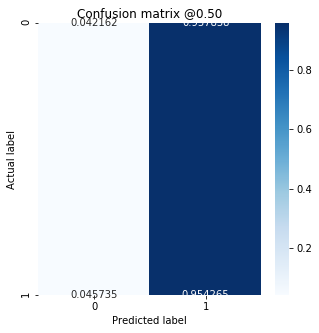

In [26]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

In [29]:
get_notebook_name()

<IPython.core.display.Javascript object>

'CNN Fundus- RUN1-Copy4.ipynb'

### MLFlow 

In [30]:
# # history = imb_history
# tag_value = "single train RUN1-Copy4 with featurewise_center = True"
# myname = get_notebook_name()
# exp_name = myname +"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [31]:
# client = MlflowClient()
# run = client.create_run('26')
# client.set_tag(run.info.run_id, "tag_key", tag_value)